# Taking off the Training Weels: Re-Balancing the Citibike System

**Author: Mitchell Krieger**
***

## Identifying Drains, Pools and Balanced Stations

Now that we've used time series analysis to forcast how many bikes are at a station, we extract seasonalities generated by the models to explore differences in how stations behave. Then we can use clustering to identify stations as bike drains, bike pools or balanced stations.

**Import Relevant Packages**

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

import pickle
import re

from src.station import *

#### Load in Data from models

In [2]:
#Read Pickle files
system_forcast = pickle.load(open('./data/pickle/system_forcast.pickle','rb'))
system_daily = pickle.load(open('./data/pickle/system_daily.pickle','rb'))

## Exploring Seasonalities & Station trends

Let's look at the extracted seasonalities of various stations:

### Balanced stations

Balanced stations' daily seasonal cycle should begin and end in the same place, and be somewhat centered around zero. If the end points are non-zero the remainder of the day should balance out the ends.

For example, a U shape like the station below tend to be in residential neighborhoods. This station shows balanced behavior because it has more bikes in the evening when commuters return home and less bikes during the day when they are at work. Because the curve is somewhat centered around zero, this station should be balanced meaning that the ebb and flow of the amount of bikes is mostly between the number of bikes taken out and the number of bikes coming in. This station is on the upper west side:

Text(0.5, 1.0, 'W 74 St & Columbus Ave \nDaily Cycle')

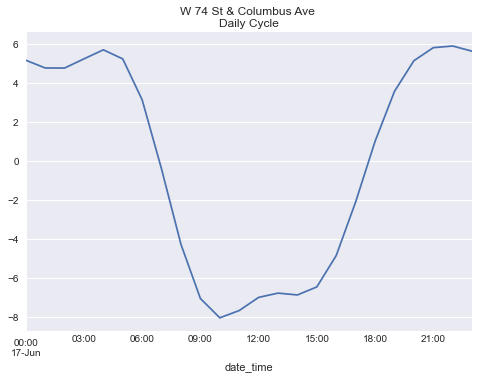

In [3]:
system_daily['2018-06-17':'2018-06-17']['daily_3172'].plot() #extracted seasonality is same for all days
plt.title('W 74 St & Columbus Ave \nDaily Cycle')

For Business districts balanced shapes will be inverted, because the communiting behavior is the opposite than stations in residential neighborhoods. This station in the Financial District is less balanced than the one above because its mean is much further from zero. This station may tend to pool bikes because its mean is positive:

Text(0.5, 1.0, 'Fulton St & Broadway\nDaily Cycle')

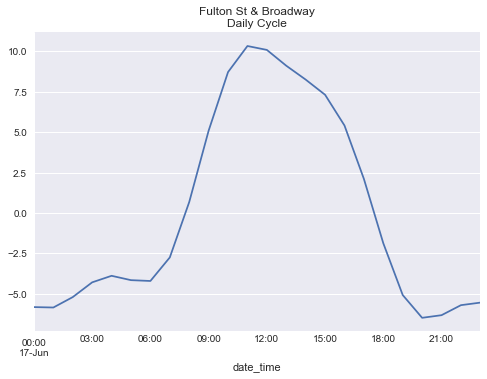

In [4]:
system_daily['2018-06-17':'2018-06-17']['daily_319'].plot()
plt.title('Fulton St & Broadway\nDaily Cycle')

### Unbalanced Stations

This station in redhook shows an slight upward trend, meaning that it is heavily likely to pool and its near zero scale indicates that the station sees little use.

Text(0.5, 1.0, 'Coffey St & Conover St\nDaily Cycle')

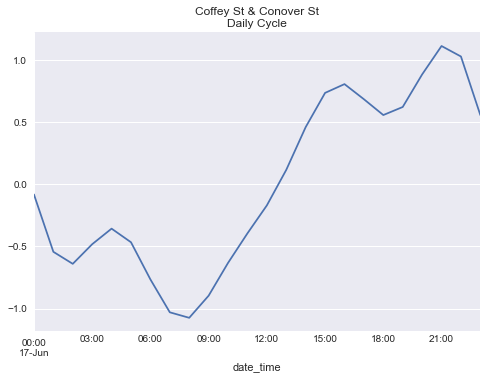

In [5]:
system_daily['2018-06-17':'2018-06-17']['daily_3348'].plot()
plt.title('Coffey St & Conover St\nDaily Cycle')

Other unbalanced shapes could include:
- U and invertered U shapes with a mean far from zero
    - Center < 0 (pool)
    - Center > 0 (drain)
- Have a trend
    - Decreasing (drain)
    - Increasing (pool)
- A flat line
    - At Zero (station is unused)
    - Below Zero (drain)
    - Above Zero (pool)

## Clustering

Now that we understand some basic patterns of seasonal curves, we'll use KMeans clustering to see if these pools, drains and balanced stations can be identified

In [6]:
#prep data for clustering by transposing to have a station be represented by each row
#and time for columns 
system_forcast = system_forcast.transpose()
system_daily = system_daily.transpose()

system_forcast.index =  pd.Index([re.findall('\d+', i)[0] for i in system_forcast.index])
system_daily.index =  pd.Index([re.findall('\d+', i)[0] for i in system_daily.index])

#scale data to allow for comparison of stations of larger capacities to stations of smaller capacities
scaler = StandardScaler()
system_forcast_scl = scaler.fit_transform(system_forcast)

### KMeans

Using various amounts of clusters, let's run the KMeans algorithm on data and get various metrics to look for an elbow

Text(0.5, 0, 'K')

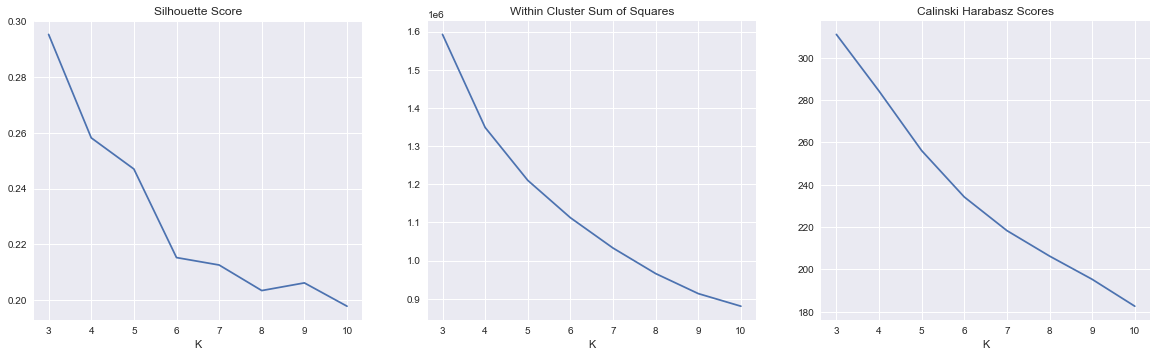

In [14]:
k_means = [] #stores clustering models fitted to scaled data
sil_scores = [] #stores silhouette scores

#fit model for each k
for k in range(3,11):
    model = KMeans(n_clusters=k,random_state=123).fit(system_forcast_scl)
    k_means.append(model)
    sil_scores.append(silhouette_score(system_forcast_scl,model.labels_))
    
#plot sil scores
fig, ax = plt.subplots(ncols=3,nrows=1)
fig.set_figwidth(20)
ax[0].plot(range(3,11),sil_scores)
ax[0].set_xticks(range(3,11))
ax[0].set_title('Silhouette Score')
ax[0].set_xlabel('K')

wcss = [model.inertia_ for model in k_means] #stores within clusters sum of squares

# plot within clusters sum of squares
ax[1].plot(range(3,11),wcss)
ax[1].set_xticks(range(3,11))
ax[1].set_title('Within Cluster Sum of Squares')
ax[1].set_xlabel('K')

#stores Calinski Harabasz Scores
CH = [calinski_harabasz_score(system_forcast_scl, model.labels_) for model in k_means]

#plot Calinski Harabasz Scores
ax[2].plot(range(3,11),CH)
ax[2].set_xticks(range(3,11))
ax[2].set_title('Calinski Harabasz Scores')
ax[2].set_xlabel('K')

There's a clear elbow at 7 clusters indicating it may have dones the best at clustering the data, however because we are only looking for major 3 categories (drain/pool/balance), 7 may be too many. Let's map the distribution of clusters to see if we can decipher if the clusters have identified pools, drains and/or balanced stations:

In [24]:
# get geopgraphic coordinates for mapping
year_2018 = pickle.load(open('./data/pickle/historical.pickle','rb'))
clusters = year_2018.droplevel(-1)[['station_name','_lat','_long']].drop_duplicates()
clusters.index = clusters.index.astype(str)
clusters = clusters[clusters.index.isin(system_forcast.index)]
clusters = clusters.reset_index().drop_duplicates(subset='station_id',
                                       keep='first').set_index('station_id')

In [25]:
#for each k model get labels for clusters and store in dataframe
for model in k_means:
    clusters['KMeans_'+str(model.n_clusters)] = [str(i) for i in model.labels_]

clusters.head(10)

,station_name,_lat,_long,KMeans_3,KMeans_4,KMeans_5,KMeans_6,KMeans_7,KMeans_8,KMeans_9,KMeans_10
station_id,,,,,,,,,,,
72,W 52 St & 11 Ave,40.767272,-73.993929,2,3,2,0,5,7,2,2
79,Franklin St & W Broadway,40.719116,-74.006667,1,0,4,4,2,4,7,7
82,St James Pl & Pearl St,40.711174,-74.000165,2,1,1,1,0,1,3,3
83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,0,2,3,3,3,6,4,4
119,Park Ave & St Edwards St,40.696089,-73.978034,2,3,2,2,4,7,2,2
120,Lexington Ave & Classon Ave,40.686768,-73.959282,2,3,2,0,5,7,1,1
127,Barrow St & Hudson St,40.731724,-74.006744,0,3,2,0,1,2,8,8
128,MacDougal St & Prince St,40.727103,-74.002971,1,0,4,4,2,4,0,0
143,Clinton St & Joralemon St,40.692395,-73.993379,1,0,4,4,2,4,7,7


In 7 clusters, we can see that its picked up on some areas of clear drainage in areas like Upper East Side and Harlem (cluster 0) and poolage in areas like Red Hook & Long Island City (cluster 1), but other thatn that its hard to tell what the other 5 clusteres mean:

In [39]:
import json

#get mapbox API key for plotting
path = '/Users/mitchellkrieger/.secret/mapbox_api.json'

with open(path) as f:
    api = json.load(f)
    
api_key = api['api_token']

#plot
px.set_mapbox_access_token(api_key)
fig = px.scatter_mapbox(clusters, lat="_lat", lon="_long",
                        hover_name='station_name',hover_data=clusters.columns[2:],
                        color='KMeans_7', zoom=11,width=800,height=800, 
                        labels={'KMeans_7':'Clusters'})

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

Because 7 clusters was too hard to decipher, let's reduce the number of clusters. When we reduce the clusters to 5 it becomes much more apparent what the clusters represent based on insights gains from exploratory data analysis:

- Pools
- Drains
- Balanced - Business Districts
- Balanced - Residential Areas 
- Slight pools (note this category is the least clear/often misclassified)
    


In [35]:
#for our most meaningful model, k=5 map identified trends to clusters
clusters['KMeans_5_named'] = clusters.KMeans_5.map({'2':'Slight Pool','4':'Balanced - Business District','1':'Drain',
                               '3':'Pool','0':'Balanced - Residential'})

In [40]:
#plot
fig = px.scatter_mapbox(clusters, lat="_lat", lon="_long",
                        hover_name='station_name',hover_data=clusters.columns[1:3],
                        color='KMeans_5_named', zoom=11,width=800,height=800, 
                        labels={'KMeans_5_named':'Clusters'}, 
                        title = 'Stations by Cluster: Pools, Drains and Balanced',
                        color_discrete_sequence=['red','darkorange','yellowgreen','forestgreen','dodgerblue'],
                        category_orders={'KMeans_5_named':['Pool',
                                                           'Slight Pool',
                                                           'Balanced - Residential',
                                                           'Balanced - Business District',
                                                           'Drain'
                                                          ]})

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

Areas with pools and drains are evident from the above clustering. Bikes pool in mostly Brooklyn perhaps because less people are using them for commuting due to its distance from Manhattan and east river making communiting harder if you don't have access to a bridge. Bikes drain from Upper East Side/East Harlem and the outer edges of the system such as Long Island City and deeper into Brooklyn. Midtown also has a decent amount of drains, although this may be because of the lack of a "slight drain" category (increasing to 6 clusters did not reveal such a trend). These clusters also reflect the pools and drains identified visually in the animated map above.

## Agglomerative Clustering

Let's also try agglomerative clustering to see if it clusters stations better:

In [66]:
#complete agglomerative clustering
complete_agg = AgglomerativeClustering(linkage='complete',n_clusters=5)
comp_clusters = complete_agg.fit_predict(system_forcast)
clusters['complete_agg'] = comp_clusters.astype(str)

#ward agglomerative clustering
ward_agg = AgglomerativeClustering(linkage='ward',n_clusters=5)
ward_clusters = ward_agg.fit_predict(system_forcast)
clusters['ward_agg'] = ward_clusters.astype(str)

Complete linkage with 5 clusters, leads to a significant misclassification of the Upper East side, clustering it with the main business districts in midtown and downtown/financial district. Ward linkage on the other hand captures similar trends to KMeans in Mahattan, but has a distinct Brooklyn class, as seen in the map below. However, its unclear what kind of trend related to the rebalancing problem this cluster is identifying and it misses stations that are clear drains on the system's edge in Booklyn (Park Slope Area)

In [67]:
#plot agglom clusters
fig = px.scatter_mapbox(clusters, lat="_lat", lon="_long",
                        hover_name=clusters.index,hover_data=clusters.columns[2:],
                        color='ward_agg',
                        zoom=12.5,width=800,height=800)

fig.show()

By examining the demdrogram using ward linkage we can see that 5 clusters is quite close in distance to 4 clusters:

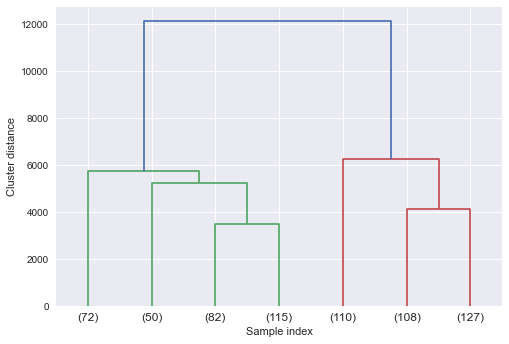

In [68]:
from scipy.cluster.hierarchy import dendrogram, ward
w = ward(system_forcast)
dendrogram(w, truncate_mode='lastp', p=7)

ax = plt.gca()
bounds = ax.get_xbound()
plt.xlabel('Sample index')
plt.ylabel('Cluster distance');

Decreaseing to solves the issue of an unclear special class for Brooklyn and some of the misclssification of Drain's on the systems edge. Because, KMeans provided a somewhat more nuaced clustering with slight pools (although not compltely unique from balanced/pools), we'll use KMeans with 5 clusters as our final clustering algorithm for deplotment.

In [69]:
#ward agglomerative clustering
ward_agg = AgglomerativeClustering(linkage='ward',n_clusters=4)
ward_clusters = ward_agg.fit_predict(system_forcast)
clusters['ward_agg_4'] = ward_clusters.astype(str)

#plot 4 agglom clusters
fig = px.scatter_mapbox(clusters, lat="_lat", lon="_long",
                        hover_name=clusters.index,hover_data=clusters.columns[2:],
                        color='ward_agg_4',
                        zoom=12.5,width=800,height=800)

fig.show()

## Conclusion

Facebook Prophet clearly has the best metrics on both the train and test set as well as most closely demonstrating the weekly and daily seasonality present in the citibike system. In addition because of its ability to easily handle missing data, it performed almost as well when cross validated throughout the year with a horizon of 22-23 days. This possibly indicates that adding yearly seasonality may only marginally increase the performance of the model. With an RMSE Score of 6.3 and an MAE of 5.15, the model is off about 5-6 bikes on average. Considering that stations usually have a bike capacity of between 20-50, a 5-6 bike error is actually quite large (10%-20%). However, the purpose of the this project is to use the trends found in predicting available bikes to cluster bikes into pools, drains, or balanced. So while this large error is not ideal, the model does capture daily and weekly seasonality extremely well, which is perhaps more important for clustering purposes, and as a result ultimately was selected over the CNN-LSTM model which was more accurate in its bike count but less attentive to seasonality.

Once we could use use the facebook prophet time series model to somewhat accurately predict the number of bikes at a given station, we can extract the daily/weekly seasonality of the model to classify stations as pools, drains or balanced via clustering. The clustering process clearly shows areas of poolage (Brooklyn) vs drainage (Upper East Side/Harlem/System Edge) and citibike can use these models/clusters to select stations to take bikes from due to an abundance of bikes and redistribute them to stations in need of more bikes. Citibike should also think about how to use seasonality to its advantage when rebalancing the system. Bikes tend to freeze in place overnight (as seen in EDA), which may be a good time for redistribution. Plus, because there is a large spike during rush hour every daily season, it may be advantageous to attempt to redistribute bikes during the after the morning commute during business hours to business areas in anticipation of the evening commute rush. In addition it may be wise to consider establishing new stations in areas with many drains/pools. The newly added fleet of electric bikes can also help by allowing riders to get further distances and scale steeper elevations within the rider time limit.

Since 2018, the number of stations active in the system have nearly doubled, expanding deeper into Queens and Brooklyn as well as expanding into Upper Manahttan and the Broxs. Therefore, this analysis may need to be reconducted once additional data is collected to assess if any stations have changed in their behavior (particularly around where the former edges of the system are). In addition, COVID-19 may have deeply affected rider behavior, and may cause massive changes to the system. 

## Next Steps

Next steps are to:

- Incorporate Exgoneous Variables such as holidays, weather, electric bikes and elevation
- Collect data additional data and run analysis on 2020/2021 as Citibike has since 2018 expanded greatly into the Bronx, Washington Heights & Upper Harlem, and deeper into Queens and brooklyn.
- Analyze the impact of COVID-19 on changes rider behavior and station trends/clustering.
- Refine clustering process to include "slight drains"